## Iinitiation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from fastai.model import *


In [3]:
PATH = 'data/dogs-breed/'

In [4]:
ls {PATH}

labels.csv  models/  sample_submission.csv  test/  tmp/  train/


## Data analysation 

In [5]:
from fastai.plots import *

In [6]:
model = resnext50

In [7]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
lable_table = pd.read_csv(label_csv)
lable_table.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [9]:
def get_data(sz,bs=64):
    tfms = tfms_from_model(model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test',bs=bs)

In [10]:
data = get_data(256,64)

In [11]:
fn = f'{PATH}{data.trn_ds.fnames[0]}'

In [12]:
fn

'data/dogs-breed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

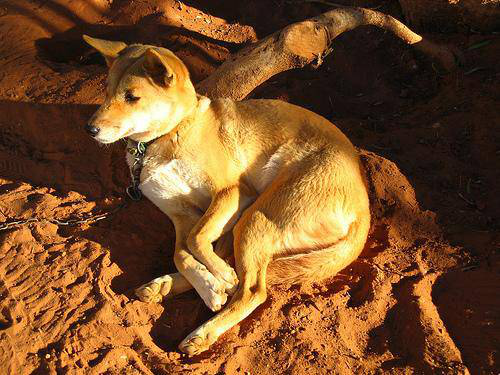

In [13]:
img = Image.open(fn) ; img

In [14]:
img.size

(500, 375)

### Plots

In [15]:
sizes = [Image.open(f"{PATH}{img_pic}").size for img_pic in data.trn_ds.fnames]
row_size,col_size = zip(*sizes)

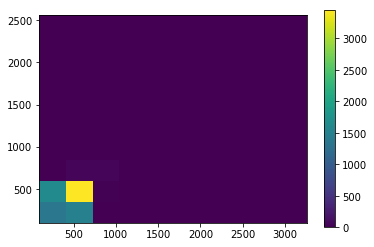

In [16]:
heatmap,xeg,yeg = np.histogram2d(row_size,col_size)
ext = [xeg[0],xeg[-1],yeg[0],yeg[-1]]
_=plt.imshow(heatmap.T,extent=ext,origin="lower")
_=plt.colorbar()

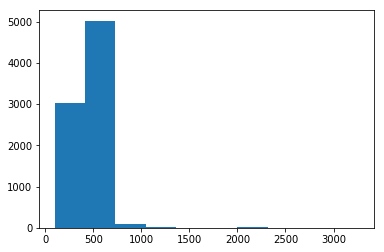

In [17]:
plt.hist(row_size);

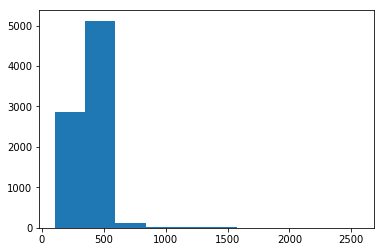

In [18]:
plt.hist(col_size);

#### avg size

In [19]:
(np.mean(row_size),np.mean(col_size))

(442.77427243824894, 385.7891905111274)

### Play with the data

In [20]:
x,y = next(iter(data.val_dl))

In [21]:
len(y)

64

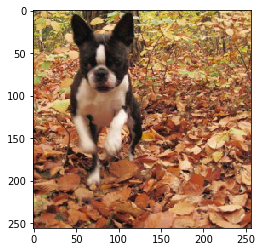

In [22]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In [23]:
type(lable_table["id"] == "002211c81b498ef88e1b40b9abf84e1d")

pandas.core.series.Series

In [24]:
lable_table[lable_table["id"] == "002211c81b498ef88e1b40b9abf84e1d"]

,id,breed
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier


## Train

### find learning rate

In [25]:
sz=256
bs=180

In [26]:
data = get_data(sz,bs)

In [27]:
learn = ConvLearner.pretrained(model, data,precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      3.198347   16.279583  0.532986  



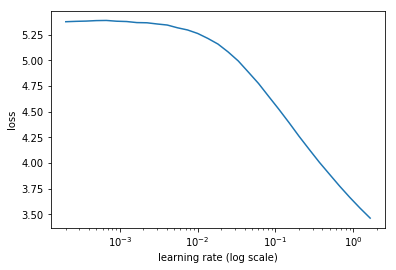

In [28]:
lrf=learn.lr_find()
learn.sched.plot()

In [29]:
lr = 0.2

### fit

In [30]:
learn.fit(lr, 3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.052411   0.369048   0.899711  
    1      0.56018    0.334495   0.907957                  
    2      0.378227   0.294966   0.912211                  



[0.29496576885382336, 0.9122106532255808]

In [31]:
learn.precompute=False
learn.fit(lr, 2,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.294778   0.274189   0.917216  
    1      0.273523   0.293798   0.906916                  



[0.29379816725850105, 0.9069155057271322]

#### add new bigger data as new data

In [32]:
sz = 299
learn.set_data(get_data(sz,bs))

In [33]:
learn.precompute=False
learn.fit(lr, 2,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.258776   0.283121   0.909693  
    1      0.252878   0.290197   0.912297                  



[0.2901968794564406, 0.9122974475224813]

#### fit little bit the modle

In [ ]:
lrs = [1e-5,1e-4,lr/10]
learn.set_data(get_data(sz,20))
learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs, 2,cycle_len=1,cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot_loss()

## Finish

In [34]:
log_preds,y = learn.TTA()

In [35]:
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs, y)

0.9143835616438356

### predict single image

In [37]:
learn.precompute=False
trn_tfms,val_tfms = tfms_from_model(model,64)
test_img = open_image(f'{PATH}train/00290d3e1fdd27226ba27a8ce248ce85.jpg')
im = val_tfms(test_img)
pred = learn.predict_array(im[None])
result = np.argmax(pred);result

27

In [38]:
result

27

In [39]:
lable_table[lable_table["id"] == "00290d3e1fdd27226ba27a8ce248ce85"]

,id,breed
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier


In [40]:
data.classes[result]

'cardigan'

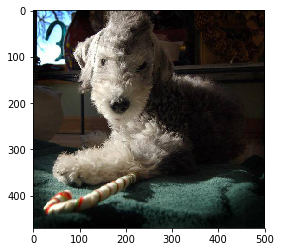

In [42]:
plt.imshow(test_img);

### End

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)
